# Tarea 2
## Francisco Javier Peralta Ramírez

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

import warnings
sp.init_printing()
warnings.filterwarnings('ignore')

In [2]:
def nag(f, gradf, x0, nIter, alpha, eta):
    assert alpha > 0 and eta > 0#positive step size
    a, e, x = alpha, eta, x0
    #primer paso es desenso de gradiente...
    p = gradf(x)
    fx = [f(x)]
    x = x - a * p
    #empieza NAG
    fx.append(f(x))
    for i in range(nIter - 1): #ya hicimos la primera iteracion...
        xn = x - a * p #tomamos el paso anterior
        gt = gradf(xn)
        p = e * p + gt #nueva dir
        x = xn -  a * p
        fx.append(f(x))
    return np.array(fx), x

In [3]:
def adagrad(f, gradf, x0, nIter, alpha, epsilon = 0.001):
    x = x0
    g2 = np.zeros_like(x)
    fx = [f(x)]
    for i in range(nIter):
        g = gradf(x)
        g2 += g**2 #suma cuadrada de gradientes
        n = alpha / np.sqrt(g2 + epsilon)
        x = x - n * g
        fx.append(f(x))
    return np.array(fx), x

In [4]:
def adam(f, gradf, x0, nIter, alpha, beta = (0.9, 0.999), epsilon = 1E-8):
    x = x0
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    fx = [f(x)]
    
    for i in range(nIter):
        g = gradf(x)
        m = beta[0] * m + (1 - beta[0]) * g    #decaying avg momentum
        v = beta[1] * v + (1 - beta[1]) * g**2 #decaying velocity
        #bias corrected first and second moments
        mh = m / ( 1 - beta[0])
        vh = v / ( 1 - beta[1])
        x = x - alpha * mh / (np.sqrt(vh) + epsilon)
        fx.append(f(x))
    return fx, x

Codificamos la función rosembrock como un simple **for**

In [5]:
def rosenbrock(x):
    fx = 0
    for i in range(len(x) - 1):
        fx += 100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2
    return fx

Como la función *rosenbrock* admite cualquier tipo (i.e. no se hace chequeo de tipos) podemos pasar simbolos de *sympy*

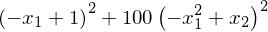

In [6]:
x = sp.symbols('x1:3')
rosenbrock(x)

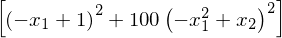

In [7]:
ros = sp.Matrix([rosenbrock(x)])
ros

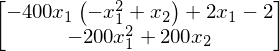

In [8]:
jacRos = ros.jacobian(x).T
jacRos

Podemos evaluar el resultado del gradiente usando la función **subs** la cual substituye las variables por valores, esta requiere un parámetro de la forma ***[ (old, new), ... ]*** donde *old* es la variable a remplazar y *new* el valor.

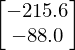

In [9]:
x0 = [-1.2, 1]
evalJ = jacRos.subs([(x[i], x0[i]) for i in range(len(x0))])
evalJ

Podemos juntar todo esto para crear una función que regresa el gradiente

In [10]:
def sym_grad(f, x):
    x_s = sp.symbols('x0:{}'.format(len(x)))
    mtx = sp.Matrix([f(x_s)])
    jac = mtx.jacobian(x_s)
    evl = jac.subs([(x_s[i], x[i]) for i in range(len(x0))])
    return np.array( [float(v) for v in evl])
sym_grad(rosenbrock, x0) #comprobamos funcionamiento

#mucho mas rapido con lamdify
def sym_grad2(f, k):
    x_s = sp.symbols('x0:{}'.format(k))
    mtx = sp.Matrix([f(x_s)])
    jac = mtx.jacobian(x_s)
    jac_f  = [sp.lambdify(x_s, jac[i]) for i in range(k)]
    def __gradient(x):
        return np.array([ jac_f[i](*x) for i in range(k)])
    return __gradient

def sym_grad_batch(f, x, syms):
    pass

In [11]:
rosenbrock_grad = sym_grad2(rosenbrock, len(x0))

In [12]:
nag(rosenbrock, rosenbrock_grad, x0, 10, 0.001, .5)[0]

array([24.2       ,  5.35291158, 19.52528548,  4.58113728,  4.75316463,
        6.15174762,  3.75940649,  4.19228526,  3.68422386,  3.75607264,
        3.64109028])

In [13]:
adagrad(rosenbrock, rosenbrock_grad, x0, 10, 1)[0]

array([ 24.2       , 385.59997303,  20.18288904,  45.93722297,
        81.80565154,   3.47473215,   3.44412215,   3.42676314,
         3.41431123,   3.40459526,   3.39600965])

In [14]:
adam(rosenbrock, rosenbrock_grad, x0, 10, .1)[0]

Comparamos los resultados de **NAG, ADAGRAD, ADAM** para *Rosenbrock* con $n = 2$ y $x_0 = [-1.2, 1]$

In [15]:
def plot_res(nag_res, adagrad_res, adam_res, nIter):
    f, ax = plt.subplots(1, 2, figsize=(24, 8))

    ax[0].plot(nag_res[0], label="NAG")
    ax[0].plot(adagrad_res[0], label="ADAGRAD")
    ax[0].plot(adam_res[0], label="ADAM")
    ax[0].legend()

    ax[1].plot(nag_res[0])
    ax[1].plot(adagrad_res[0])
    ax[1].plot(adam_res[0])
    ax[1].set_xlim(nIter - 10, nIter)
    upper_bound = np.max([nag_res[0][-1], adagrad_res[0][-1], adam_res[0][-1]])
    ax[1].set_ylim(0, upper_bound * 1.5)
    plt.show()

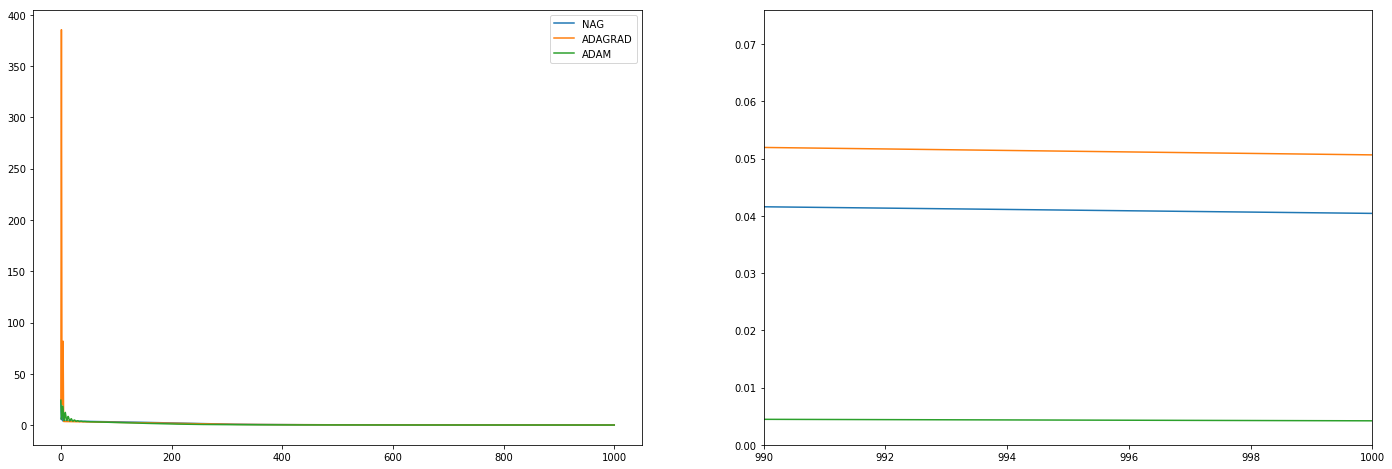

NAG: 0.04044081826413241	ADAGRAD: 0.05066649863543333	ADAM: 0.0041921266472425825
CPU times: user 254 ms, sys: 6.84 ms, total: 260 ms
Wall time: 273 ms


In [16]:
%%time
x0 = [-1.2, 1]
n_iter = 1000
rosenbrock_grad = sym_grad2(rosenbrock, len(x0))
nag_res = nag(rosenbrock, rosenbrock_grad, x0, n_iter, 0.001, 0.2)
adagrad_res = adagrad(rosenbrock, rosenbrock_grad, x0, n_iter, 1)
adam_res = adam(rosenbrock, rosenbrock_grad, x0, n_iter, 0.1)

plot_res(nag_res, adagrad_res, adam_res, n_iter)
print("NAG: {0}\tADAGRAD: {1}\tADAM: {2}".format(nag_res[0][-1], adagrad_res[0][-1] , adam_res[0][-1]))

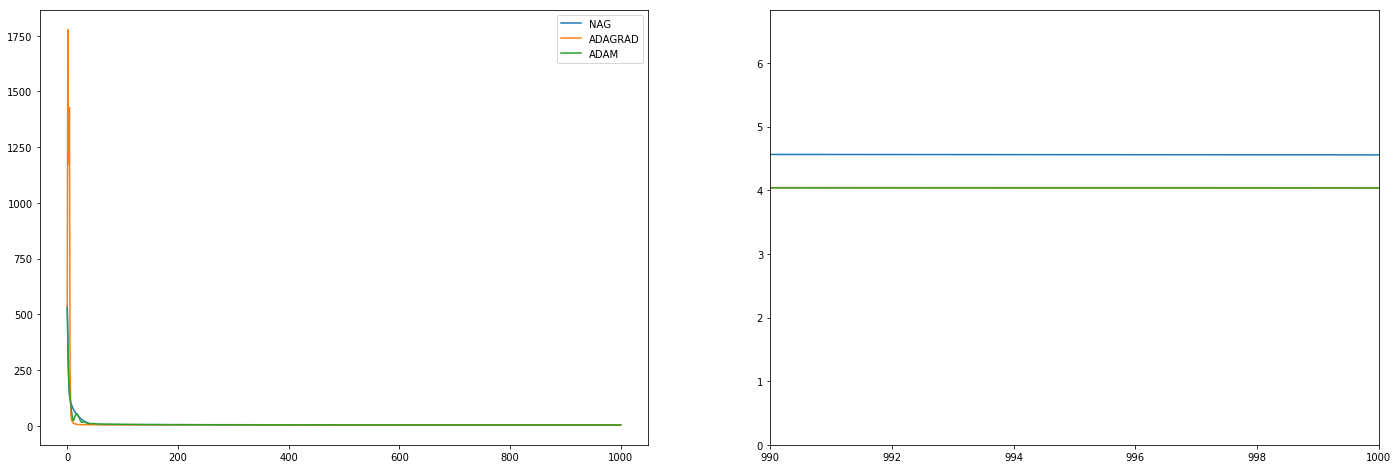

NAG: 4.557336327240701	ADAGRAD: 4.041426698185052	ADAM: 4.036033506453513
CPU times: user 394 ms, sys: 12.5 ms, total: 406 ms
Wall time: 407 ms


In [17]:
%%time
x0 = np.ones((10))
x0[0] = x0[-2] = -1.2
rosenbrock_grad = sym_grad2(rosenbrock, len(x0))
n_iter = 1000
nag_res = nag(rosenbrock, rosenbrock_grad, x0, n_iter, 0.0001, 0.5)
adagrad_res = adagrad(rosenbrock, rosenbrock_grad, x0, n_iter, 1)
adam_res = adam(rosenbrock, rosenbrock_grad, x0, n_iter, 0.1)

plot_res(nag_res, adagrad_res, adam_res, n_iter)
print("NAG: {0}\tADAGRAD: {1}\tADAM: {2}".format(nag_res[0][-1], adagrad_res[0][-1] , adam_res[0][-1]))

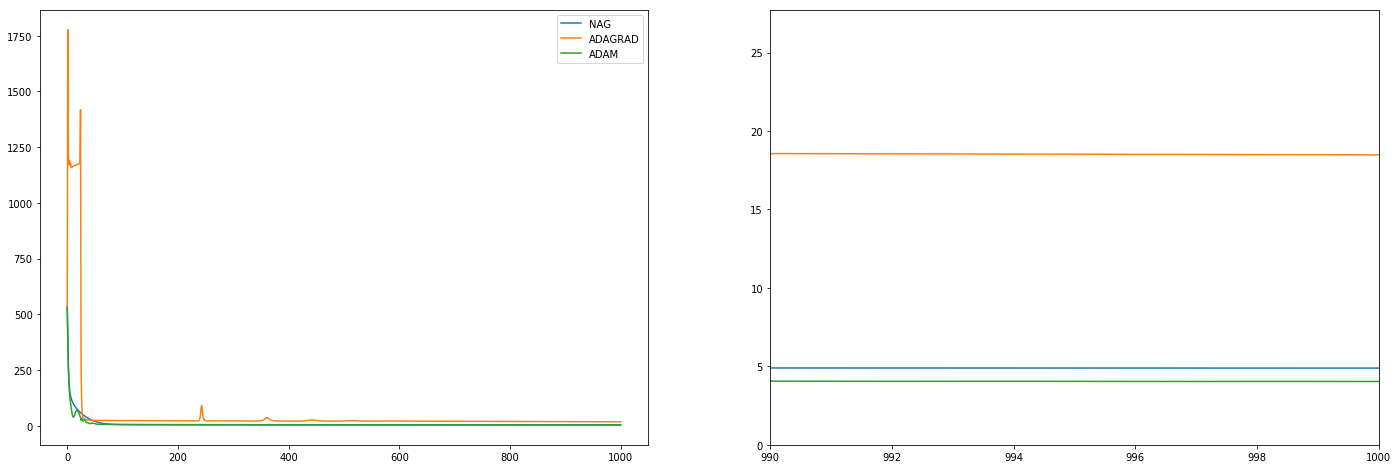

NAG: 4.888539896604424	ADAGRAD: 18.477450990168645	ADAM: 4.0349209164270885
CPU times: user 1.67 s, sys: 6.3 ms, total: 1.68 s
Wall time: 1.68 s


In [18]:
%%time
x0 = np.ones((50))
x0[0] = x0[-2] = -1.2
rosenbrock_grad = sym_grad2(rosenbrock, len(x0))
n_iter = 1000
nag_res = nag(rosenbrock, rosenbrock_grad, x0, n_iter, 0.0001, 0.2)
adagrad_res = adagrad(rosenbrock, rosenbrock_grad, x0, n_iter, 1)
adam_res = adam(rosenbrock, rosenbrock_grad, x0, n_iter, 0.1)

plot_res(nag_res, adagrad_res, adam_res, n_iter)
print("NAG: {0}\tADAGRAD: {1}\tADAM: {2}".format(nag_res[0][-1], adagrad_res[0][-1] , adam_res[0][-1]))

In [19]:
data = np.load('data.npy')

In [20]:
def radial_gauss(x, mu, sigma, lib=sp):
    expv = (x - mu)**2 / (2 * sigma**2)
    return lib.exp(-expv)

def radial_fit(x, mu, sigma, c, lib=sp):
    val = c[0]
    for i in range(len(mu)):
        val += c[i+1] * radial_gauss(x, mu[i], sigma[i], lib)
    return val

def radial_err(x, y, mu, sigma, c, lib=sp):
    err = 0
    for i in range(len(y)):
        err += (radial_fit(x[i], mu, sigma, c, lib) - y[i])**2
    return err

def create_radial_err_fun(x, y, msc):
    def fun(val):
        k = int(np.floor(len(msc)/3))
        mu, sigma, c = msc[:k], msc[k:2*k], msc[2*k:]
        errf = radial_err(x, y, mu, sigma, c, sp)
        errL = sp.lambdify(msc, errf)
        return errL(*val)
    return fun

In [21]:
radial_err(data[:10, 0], data[:10, 1], np.array([0, 1, 2]), np.array([1, 2, 3]), np.array([0, 1, 2, 3]))

In [22]:
k = 3
c = sp.symbols('c0:{}'.format(k + 1))
mu = sp.symbols('m0:{}'.format(k))
sigma = sp.symbols('s0:{}'.format(k))

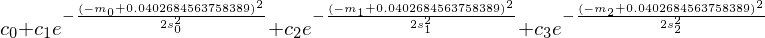

In [23]:
radial_fit(data[1:2, 0][0], mu ,sigma, c, sp)

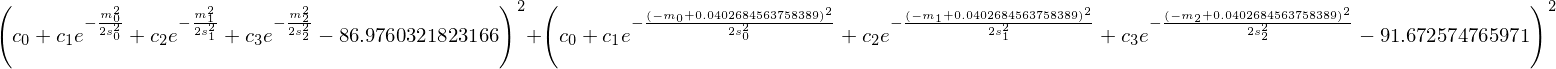

In [24]:
radial_err(data[:2, 0], data[:2, 1], mu ,sigma, c, sp)

In [25]:
def radial_err_pdif(x, y, mu, sigma, c):
        """mask: a bookean array that indicates the 
        symbols we need to derive with respect to.
        Derivatives wil be wrt mu, then sigma then c"""
        fun = radial_err(x, y, mu, sigma, c, sp) #use sympy
        partials = [0] * (len(mu) * 3 + 1)
        k = 0
        for i in range(len(mu)):
            partials[k] = sp.diff(fun, mu[i])
            k +=1
        for i in range(len(sigma)):
            partials[k] = sp.diff(fun, sigma[i])
            k +=1
        for i in range(len(c)):
            partials[k] = sp.diff(fun, c[i])
            k +=1
        return partials
    
def create_radial_err_pdif_fun(x, y, msc, batch=20):
    p = [i for i in range(len(data))]
    def fun(val):
        idxs = np.random.choice(p, batch)
        k = int(np.floor(len(msc)/3))
        mu, sigma, c = msc[:k], msc[k:2*k], msc[2*k:]
        errdif  =  radial_err_pdif(x[idxs], y[idxs], mu, sigma, c)
        errdifL = [sp.lambdify(msc, errdif[i]) for i in range(len(val))]
        return np.array([errdifL[i](*val) for i in range(len(val))])
    return fun

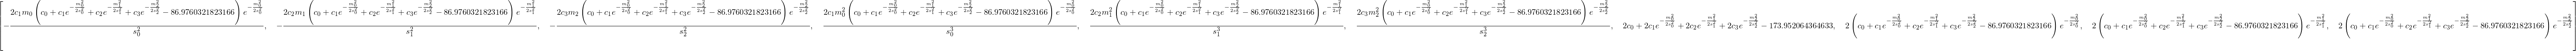

In [26]:
radial_err_pdif(data[:1, 0], data[:1, 1], mu, sigma, c)

In [27]:
%%time
x, y = data[:, 0], data[:, 1]
msc = (mu + sigma + c)
gradf = create_radial_err_pdif_fun(x, y, msc, batch=30)
f = create_radial_err_fun(x, y, msc)
cm = data[:,1].mean()
mus = np.random.choice(6, 3, replace=False)
mus.sort()
x0 = np.append(mus, [1, 1, 1, 0, cm, cm, cm])
print(x0)

[ 1.          3.          5.          1.          1.          1.
  0.         79.57087455 79.57087455 79.57087455]
CPU times: user 0 ns, sys: 855 µs, total: 855 µs
Wall time: 767 µs


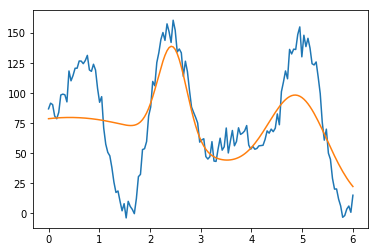

CPU times: user 15min 33s, sys: 137 ms, total: 15min 33s
Wall time: 15min 36s


In [28]:
%%time
nag_res = nag(f, gradf, x0, 200, 0.000001, 0.1)
# print(nag_res)
plt.plot(x, y)
plt.plot(x, radial_fit(x, nag_res[1][:3], nag_res[1][3:6], nag_res[1][6:], np))
plt.show()

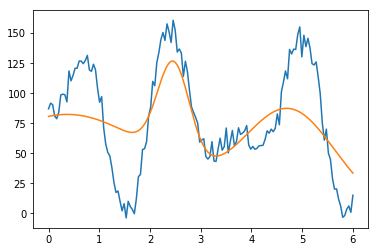

CPU times: user 15min 15s, sys: 418 ms, total: 15min 16s
Wall time: 15min 19s


In [29]:
%%time
adagrad_res = adagrad(f, gradf, x0, 200, .1)
# print(adagrad_res)
plt.plot(x, y)
plt.plot(x, radial_fit(x, adagrad_res[1][:3], adagrad_res[1][3:6], adagrad_res[1][6:], np))
plt.show()

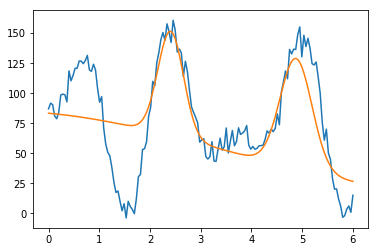

CPU times: user 14min 35s, sys: 158 ms, total: 14min 35s
Wall time: 14min 37s


In [30]:
%%time
adam_res = adam(f, gradf, x0, 200, 0.1)
# print(adam_res)
plt.plot(x, y)
plt.plot(x, radial_fit(x, adam_res[1][:3], adam_res[1][3:6], adam_res[1][6:], np))
plt.show()

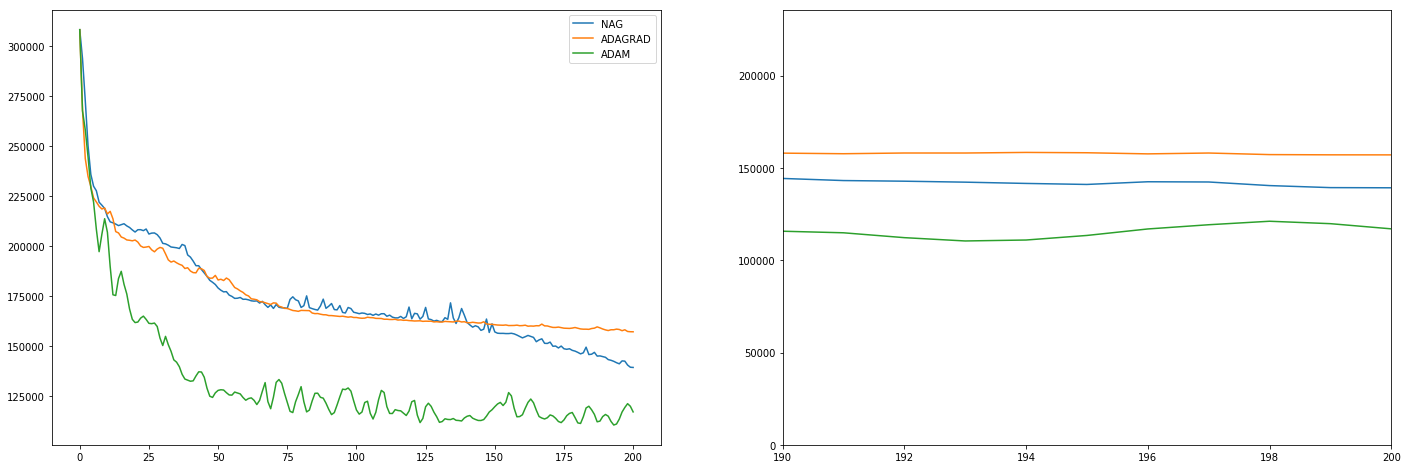

NAG: 139251.1674277976	ADAGRAD: 157085.19864293773	ADAM: 117008.39379503088


In [31]:
plot_res(nag_res, adagrad_res, adam_res, 200)
print("NAG: {0}\tADAGRAD: {1}\tADAM: {2}".format(nag_res[0][-1], adagrad_res[0][-1] , adam_res[0][-1]))

In [32]:
%%time
k = 5
c = sp.symbols('c0:{}'.format(k + 1))
mu = sp.symbols('m0:{}'.format(k))
sigma = sp.symbols('s0:{}'.format(k))
x, y = data[:, 0], data[:, 1]
msc = (mu + sigma + c)
gradf = create_radial_err_pdif_fun(x, y, msc, batch=30)
f = create_radial_err_fun(x, y, msc)
cm = data[:,1].mean()
mus = np.random.choice(6, k, replace=False)
mus.sort()
x0 = np.append(mus, [1]*k + [0]+ [cm]*k)
print(x0, len(x0))

[ 0.          1.          3.          4.          5.          1.
  1.          1.          1.          1.          0.         79.57087455
 79.57087455 79.57087455 79.57087455 79.57087455] 16
CPU times: user 1.15 ms, sys: 0 ns, total: 1.15 ms
Wall time: 946 µs


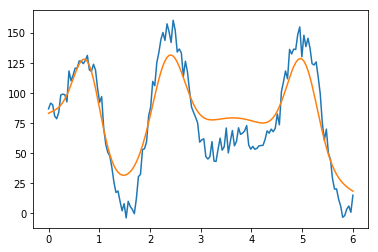

CPU times: user 26min 36s, sys: 326 ms, total: 26min 36s
Wall time: 26min 40s


In [33]:
%%time
nag_res = nag(f, gradf, x0, 200, 0.000001, 0.1)
# print(nag_res)
plt.plot(x, y)
plt.plot(x, radial_fit(x, nag_res[1][:k], nag_res[1][k:2*k], nag_res[1][2*k:], np))
plt.show()

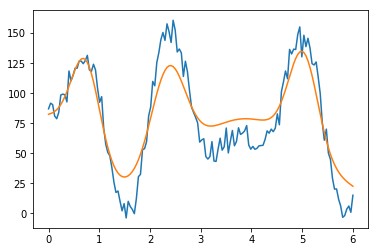

CPU times: user 26min 44s, sys: 340 ms, total: 26min 44s
Wall time: 26min 48s


In [34]:
%%time
adagrad_res = adagrad(f, gradf, x0, 200, .1)
# print(adagrad_res)
plt.plot(x, y)
plt.plot(x, radial_fit(x, adagrad_res[1][:k], adagrad_res[1][k:2*k], adagrad_res[1][2*k:], np))
plt.show()

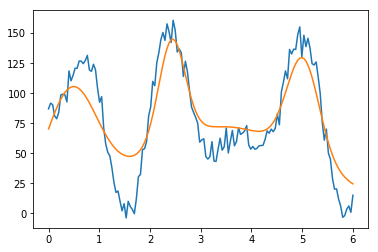

CPU times: user 26min 40s, sys: 372 ms, total: 26min 41s
Wall time: 26min 45s


In [35]:
%%time
adam_res = adam(f, gradf, x0, 200, 0.1)
# print(adam_res)
plt.plot(x, y)
plt.plot(x, radial_fit(x, adam_res[1][:k], adam_res[1][k:2*k], adam_res[1][2*k:], np))
plt.show()

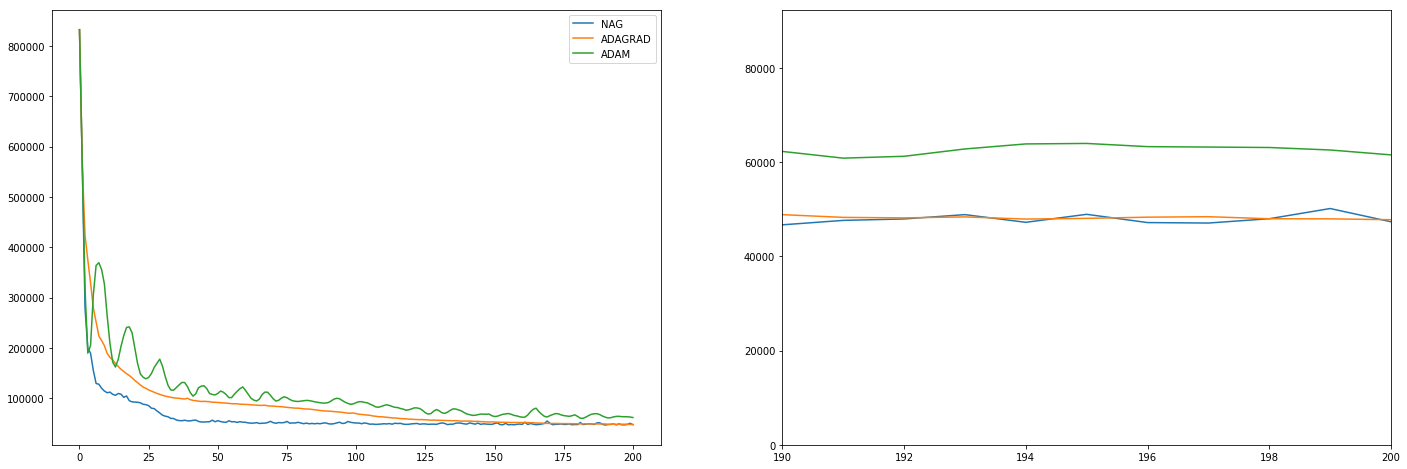

NAG: 47363.59817880463	ADAGRAD: 47805.73358058542	ADAM: 61571.21782184329


In [36]:
plot_res(nag_res, adagrad_res, adam_res, 200)
print("NAG: {0}\tADAGRAD: {1}\tADAM: {2}".format(nag_res[0][-1], adagrad_res[0][-1] , adam_res[0][-1]))

In [37]:
%%time
k = 7
c = sp.symbols('c0:{}'.format(k + 1))
mu = sp.symbols('m0:{}'.format(k))
sigma = sp.symbols('s0:{}'.format(k))
x, y = data[:, 0], data[:, 1]
msc = (mu + sigma + c)
gradf = create_radial_err_pdif_fun(x, y, msc, batch=30)
f = create_radial_err_fun(x, y, msc)
cm = data[:,1].mean()
mus = np.random.uniform(data[:, 0].min(), data[:, 0].max() ,k)
mus.sort()
x0 = np.append(mus, [1]*k + [0]+ [cm]*k)
print(x0, len(x0))

[ 0.69141806  1.4122398   3.49260275  4.63720797  4.80074715  5.5721993
  5.9462988   1.          1.          1.          1.          1.
  1.          1.          0.         79.57087455 79.57087455 79.57087455
 79.57087455 79.57087455 79.57087455 79.57087455] 22
CPU times: user 1.37 ms, sys: 0 ns, total: 1.37 ms
Wall time: 1.05 ms


In [ ]:
%%time
nag_res = nag(f, gradf, x0, 100, 0.000001, 0.1)
# print(nag_res)
# nag_res[1]
plt.plot(x, y)
plt.plot(x, radial_fit(x, nag_res[1][:k], nag_res[1][k:2*k], nag_res[1][2*k:], np))
plt.show()

In [ ]:
%%time
adagrad_res = adagrad(f, gradf, x0, 100, .1)
# print(adagrad_res)
plt.plot(x, y)
plt.plot(x, radial_fit(x, adagrad_res[1][:k], adagrad_res[1][k:2*k], adagrad_res[1][2*k:], np))
plt.show()

In [ ]:
%%time
adam_res = adam(f, gradf, x0, 100, 0.1)
# print(adam_res)
plt.plot(x, y)
plt.plot(x, radial_fit(x, adam_res[1][:k], adam_res[1][k:2*k], adam_res[1][2*k:], np))
plt.show()

In [ ]:
plot_res(nag_res, adagrad_res, adam_res, 100)
print("NAG: {0}\tADAGRAD: {1}\tADAM: {2}".format(nag_res[0][-1], adagrad_res[0][-1] , adam_res[0][-1]))